In [65]:
import os

import pandas as pd
import cv2
import numpy as np
import timm
import torch
import pytorch_lightning as pl
from torch import nn
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from timm.loss import LabelSmoothingCrossEntropy
import torch.optim as optim
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from src.dataset import get_dataloaders
from src.PLModel import Classifier
import src.train_utils as tu

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
class Config:
    seed = 31

    # data
    data_path = 'data'
    
    width = 128
    height = 128
    
    # width = 224
    # height = 224
    
    batch_size_train = 32
    batch_size_val = 256
    
    # logger
    version = 'multi_1e3_b_32_args_65'
    # version = 'multistep_05_for_last5'
    
    # train
    lr = 1e-3
    workers = 16
    max_epochs = 20
    
    # model
    model_name = 'custom_batch'
    # model_name = 'resnet18'
    # loss_name = 'cross_entropy'
    loss_name = 'smooth_cross_entropy'
    loss_args = [0.34]
    optimizer_name = 'adamw'
    # optimizer_name = 'radam'
    scheduler_name = 'MultiStepLR'
    # scheduler_name = 'empty'
    # scheduler_name = 'CyclicLR'        

## Dataloader

In [104]:
def get_transforms(height, width):
    train_transforms_ = A.Compose([
    A.Resize(height, width),
    A.ColorJitter(
        brightness=(0.65, 1.35),
        contrast=(0.5, 1.5),
        saturation=(0.5, 1.5), 
        hue=(-0.02, 0.02),
        always_apply=True, p=1),
    A.HorizontalFlip(p=0.6),
    A.ShiftScaleRotate(scale_limit=0.05, rotate_limit=35, p=0.5),
    A.GaussNoise(p=0.6),
    A.Normalize(mean=(0., 0., 0.), std=(1, 1, 1)),
    ToTensorV2()
    ])
    val_transforms_ = A.Compose([
        A.Resize(height, width),
        A.Normalize(mean=(0., 0., 0.), std=(1, 1, 1)),
        ToTensorV2()
    ])
    return train_transforms_, val_transforms_

In [105]:
train_transforms, val_transforms = get_transforms(Config.height, Config.width)
dl_train, dl_val = get_dataloaders(
    Config.data_path, train_transforms, 
    val_transforms, Config.batch_size_train, 
    Config.batch_size_val, Config.workers)

## Train

In [110]:
classifier = Classifier(
    Config.model_name, 
    Config.loss_name, 
    Config.loss_args,
    Config.optimizer_name, 
    Config.scheduler_name, 
    lr=Config.lr)

csv_logger, checkpoint_callback = tu.get_logger_and_checkpoint_callback(
    Config.model_name, Config.optimizer_name,
    Config.loss_name, Config.version)

trainer = pl.Trainer(
    max_epochs=Config.max_epochs,
    gpus=1,
    # precision=16,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    val_check_interval=1.0,
    logger=csv_logger,
    callbacks=[checkpoint_callback],
    gradient_clip_val=0.5
)

trainer.fit(classifier, dl_train, dl_val)
tu.plot_metrics(
    metrics_df_path=os.path.join(csv_logger.log_dir, 'metrics.csv'),
    save_path=os.path.join(csv_logger.log_dir)
)
extra_data = tu.get_extra_data(
    os.path.join(csv_logger.log_dir, 'metrics.csv'))
print('best cal acc', extra_data['val_acc']['max'])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/home/machinelearning/.pyenv/versions/3.9.12/envs/venv_vibe/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/machinelearning/projects/VladSchetko/imagenette_train/models/custom_batch/adamw_smooth_cross_entropy_multi_1e3_b_32_args_65 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type                       | Params
-------------------------------------------------------
0 | mo

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 814.00 MiB (GPU 0; 23.70 GiB total capacity; 20.83 GiB already allocated; 174.56 MiB free; 21.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Overfit

In [111]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from src.PLModel import model_factory, optimizer_factory, loss_factory, calculate_accuracy

overfit_batch = next(iter(dl_train))

In [108]:
model = model_factory(Config.model_name)

opt = optimizer_factory(Config.optimizer_name)(model.parameters(), lr=Config.lr)
n_iterations = Config.max_epochs
# n_iterations = 100
input_images, targets = overfit_batch

model.to('cuda:0')
input_images = input_images.to('cuda:0')
targets = targets.to('cuda:0')
loss = loss_factory(Config.loss_name)
loss_history = []
acc_history = []

pbar = tqdm(range(n_iterations))

for _ in pbar:
    predictions = model(input_images)
    acc = calculate_accuracy(predictions, targets)
    acc_history.append(acc.item())
    loss_value = loss(predictions, targets)
    loss_history.append(loss_value.item())
    pbar.set_description(f"Loss {loss_value.item()}, Acc {acc.item()}")
    opt.zero_grad()
    loss_value.backward()
    opt.step()

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 2.69 GiB (GPU 0; 23.70 GiB total capacity; 20.25 GiB already allocated; 174.56 MiB free; 21.77 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

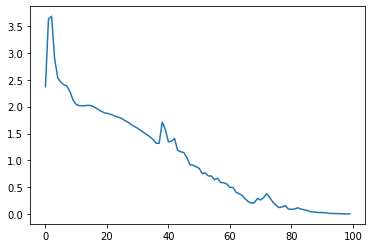

In [10]:
plt.plot(loss_history)

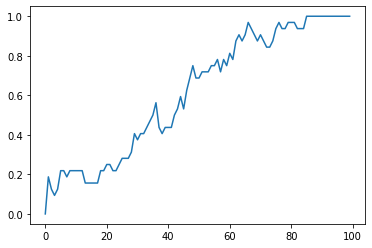

In [11]:
plt.plot(acc_history)

## Custom model

In [18]:
model = timm.create_model('resnet50', num_classes=10, pretrained=False)

In [49]:
class CustomModel(nn.Module):
    def __init__(
        self,
        channels=(3, 16, 16, 32, 64),
        kernel_size=(5, 5, 5, 3),
        batch_norm=True,
        dropout_p=0,
        max_pool_kernel=5,
    ):
        super().__init__()
        self.fe = nn.Sequential()

        for i in range(len(channels) - 2):
            self.fe.append(
                nn.Conv2d(channels[i], channels[i + 1],
                          kernel_size[i],
                          stride=1))
            if batch_norm:
                self.fe.append(nn.BatchNorm2d(channels[i + 1]))
            self.fe.append(nn.ReLU())
            if dropout_p:
                self.fe.append(nn.Dropout(p=dropout_p))
        self.fe.append(nn.Conv2d(channels[-2], channels[-1],
                                 kernel_size[-1],
                                 stride=1))
        if batch_norm:
            self.fe.append(nn.BatchNorm2d(channels[-1]))
        if max_pool_kernel:
            self.fe.append(nn.MaxPool2d(max_pool_kernel))
        self.flatten = nn.Flatten()
        self.input_ln = nn.Linear(30976, 1024)
        self.relu = nn.ReLU()
        self.output_ln = nn.Linear(1024, 10) 
        
    def forward(self, x):
        x = self.fe(x)
        x = self.flatten(x)
        x = self.input_ln(x)
        x = self.relu(x)
        x = self.output_ln(x)
        return x

In [50]:
m = CustomModel()

In [51]:
t = torch.randn(1, 3, 128, 128)

In [52]:
m(t).shape

torch.Size([1, 10])